In [5]:
from global_variables import *
AVG_OFFSETS = list(range(2, 18))
OFFSET = 2
RESULT_OFFSET = 5
CHECKPOINT_PATH = f'{CHECKPOINTS_FOLDER}training3/'
SAVE_PATH = f'{CHECKPOINTS_FOLDER}training3/'

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import normalize
import tensorflow as tf
import matplotlib.pyplot as plt

ImportError: attempted relative import with no known parent package

In [3]:
def create_trainset(file, avg_offsets = [10, 20, 35], offset = 15, result_offset = 7):
    global train_array
    with open(file, 'r') as train_file:
        for line in train_file:
            train_array = line.split(',')
    
    train_array = list(map(float, train_array))

    result_set = np.zeros(shape = (len(train_array) - max( max(avg_offsets), offset ) - result_offset , 1))
    print(np.shape(result_set))
    for num in range(len(result_set)):
        summ = sum(train_array[num + max(max(avg_offsets), offset) : num + max(max(avg_offsets), offset) + result_offset]) / RESULT_OFFSET
        if train_array[num + max(max(avg_offsets), offset)] - summ > 0:
            result_set[num, 0] = 1
        else:
            result_set[num, 0] = 0
    
    train_set = np.zeros(( len(train_array) - max(max(avg_offsets), offset) - result_offset, len(avg_offsets) + offset ))
    for position in range(len(train_set)):
        train_set[position] = fill_single_pos(train_array, avg_offsets, offset, position + max(max(avg_offsets), offset))
    
    #result_set /= np.amax(train_set)
    #train_set /= np.amax(train_set)
    np.savetxt(f'{TRAINSETS_FOLDER}trainset.txt', train_set)
    return train_set, result_set

def fill_single_pos(train_array, avg_offsets, offset, position):

    pos = np.zeros((len(avg_offsets) + offset))
    for num in range(len(avg_offsets)):
        pos[num] = (train_array[position] - sum(train_array[position - avg_offsets[num] + 1 : position + 1]) / avg_offsets[num])
    
    for num in range(offset):
        pos[num + len(avg_offsets)] = (train_array[position] - train_array[position - num])

    return pos

def create_network():
    net = Sequential()
    net.add(Flatten())
    net.add(Dense(120, activation = tf.nn.sigmoid))
    net.add(Dense(120, activation = tf.nn.sigmoid))
    net.add(Dense(1, activation = tf.nn.sigmoid))

    net.compile(optimizer = 'adam',
    loss = 'mean_absolute_error')

    return net

In [4]:
x_train, y_train = create_trainset(f'{TRAINSETS_FOLDER}btc_hour.txt', AVG_OFFSETS, OFFSET, RESULT_OFFSET)
cp_callback = tf.keras.callbacks.ModelCheckpoint(SAVE_PATH, save_weights_only = True, verbose = 1)
nn = create_network()

(25107, 1)


In [5]:
nn.load_weights(CHECKPOINT_PATH)

In [ ]:
nn.fit(x_train[:24000], y_train[:24000], epochs = 10000, callbacks = [cp_callback])

Epoch 1/10000
709/750 [===========================>..] - ETA: 0s - loss: 0.2553
Epoch 1: saving model to training3\
750/750 [==============================] - 1s 1ms/step - loss: 0.2551
Epoch 2/10000
727/750 [============================>.] - ETA: 0s - loss: 0.2529
Epoch 2: saving model to training3\
750/750 [==============================] - 1s 1ms/step - loss: 0.2526
Epoch 3/10000
731/750 [============================>.] - ETA: 0s - loss: 0.2559
Epoch 3: saving model to training3\
750/750 [==============================] - 1s 1ms/step - loss: 0.2558
Epoch 4/10000
718/750 [===========================>..] - ETA: 0s - loss: 0.2487
Epoch 4: saving model to training3\
750/750 [==============================] - 1s 1ms/step - loss: 0.2493
Epoch 5/10000
737/750 [============================>.] - ETA: 0s - loss: 0.2481
Epoch 5: saving model to training3\
750/750 [==============================] - 1s 1ms/step - loss: 0.2480
Epoch 6/10000
725/750 [============================>.] - ETA: 0s - los

115.41192968102835


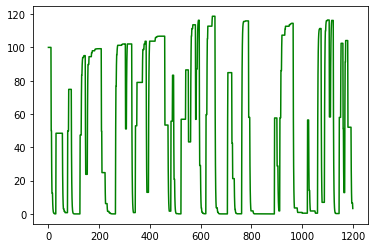

In [6]:
starting_point = 23922
end_point = 25122
output = np.zeros(end_point - starting_point)
mistakes2 = np.zeros(end_point - starting_point)
balance = 100
btc = 0
balance_array = []
btc_array = []
prev = [0 for _ in range(11)]

for num in range(starting_point, end_point):
    prediction = nn.predict(np.array([fill_single_pos(train_array, AVG_OFFSETS, OFFSET, num)]))
    prediction[0, 0] = round(prediction[0, 0])
    if prev.count(prediction[0, 0]) <= 4:
        if prediction[0, 0] == 0:
            balance /= 2
            btc += balance / train_array[num] * 0.9975
        else:
            btc /= 2
            balance += btc * train_array[num] * 0.9975
    prev[num % len(prev)] = 0 if train_array[num] - train_array[num - 1] > 0 else 1
    balance_array.append(balance)
    btc_array.append(btc)
    output[num - starting_point] = prediction[0, 0]
    mistakes2[num - starting_point] = train_array[num] - train_array[num + RESULT_OFFSET]

print(balance + btc * train_array[end_point])

plt.plot([x for x in range(len(mistakes2))], mistakes2, color = 'blue')
plt.savefig(f'{IMAGES_FOLDER}png/mistakes.png')
plt.close()
plt.plot([x for x in range(len(output))], output, color = 'red')
plt.savefig(f'{IMAGES_FOLDER}png/predictions.png')
plt.close()
plt.plot([x for x in range(len(btc_array))], btc_array, color = 'orange')
plt.savefig(f'{IMAGES_FOLDER}png/btc.png')
plt.close()
plt.plot([x for x in range(len(balance_array))], balance_array, color = 'green')
plt.savefig(f'{IMAGES_FOLDER}png/balance.png')

In [15]:
last = [63800.84,63738.93,63624.51,63878.34,64061.29,63835.77,63477.25,63744.64,63577.66,63546.03,63608.80,64752.01,64710.63,64639.35,64693.40,64142.33,63952.02,64396.23,64372.91,64294.46,64403.43]
print(nn.predict(np.array([fill_single_pos(last, AVG_OFFSETS, OFFSET, 19)]))[0, 0])

3.8911874e-09
